In [3]:
import os
import scipy.io
import numpy as np
import pandas as pd

def extract_estCSF_row(mat_path):
    """Extract last row of estCSF array from a .mat file with nested structs."""
    mat_data = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    
    # Navigate the nested structs
    qcsf_struct = mat_data['qcsf']
    data_struct = qcsf_struct.data
    estCSF = data_struct.estCSF  # estCSF should be 120x4
    return estCSF[-1, :]  # last row

# Base directory (update this to your actual path)
base_dir = '/Volumes/Seagate Desktop Drive/AVP-BDD/behavior'
subject_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Store all data in a list of dicts
all_data = []

for subj in subject_dirs:
    subj_path = os.path.join(base_dir, subj, 'qCSF')
    if not os.path.exists(subj_path):
        continue

    # All .mat files for this subject
    mat_files = [f for f in os.listdir(subj_path) if f.endswith('.mat')]
    mat_files_dict = {  # key = session number
        '-1': None,
        '-2': None
    }

    for f in mat_files:
        if '-1_' in f:
            mat_files_dict['-1'] = f
        elif '-2_' in f:
            mat_files_dict['-2'] = f

    # Initialize row with subject ID and NaNs
    row = {
        'subject': subj,
        'sensitivity-1': np.nan, 'peakSF-1': np.nan, 'bandwidth-1': np.nan, 'sftrunc-1': np.nan,
        'sensitivity-2': np.nan, 'peakSF-2': np.nan, 'bandwidth-2': np.nan, 'sftrunc-2': np.nan
    }

    for session in ['-1', '-2']:
        mat_file = mat_files_dict[session]
        if mat_file is not None:
            mat_path = os.path.join(subj_path, mat_file)
            try:
                last_row = extract_estCSF_row(mat_path)
                row[f'sensitivity{session}'] = last_row[0]
                row[f'peakSF{session}']      = last_row[1]
                row[f'bandwidth{session}']   = last_row[2]
                row[f'sftrunc{session}']     = last_row[3]
            except Exception as e:
                print(f"Error loading {mat_file} for {subj}: {e}")

    all_data.append(row)

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Preview results
print(df.head())

# Clean version (for test-retest only)
df_clean = df.dropna(subset=['sensitivity-1', 'sensitivity-2'])  # adjust based on needs


  subject  sensitivity-1  peakSF-1  bandwidth-1  sftrunc-1  sensitivity-2  \
0     102       2.170925  0.503809     0.286222  -1.104826       2.212536   
1     103       2.332482  0.363353     0.365970  -1.064299       2.298157   
2     104       2.282790  0.354120     0.421914  -1.010116       2.349551   
3     105       2.313569  0.458691     0.312722  -1.042016       2.261258   
4     106            NaN       NaN          NaN        NaN       2.027031   

   peakSF-2  bandwidth-2  sftrunc-2  
0  0.233349     0.454341  -1.043752  
1  0.459820     0.321856  -0.868089  
2  0.646488     0.232143  -1.081311  
3  0.419857     0.346994  -0.873733  
4  0.246156     0.449556  -0.984510  


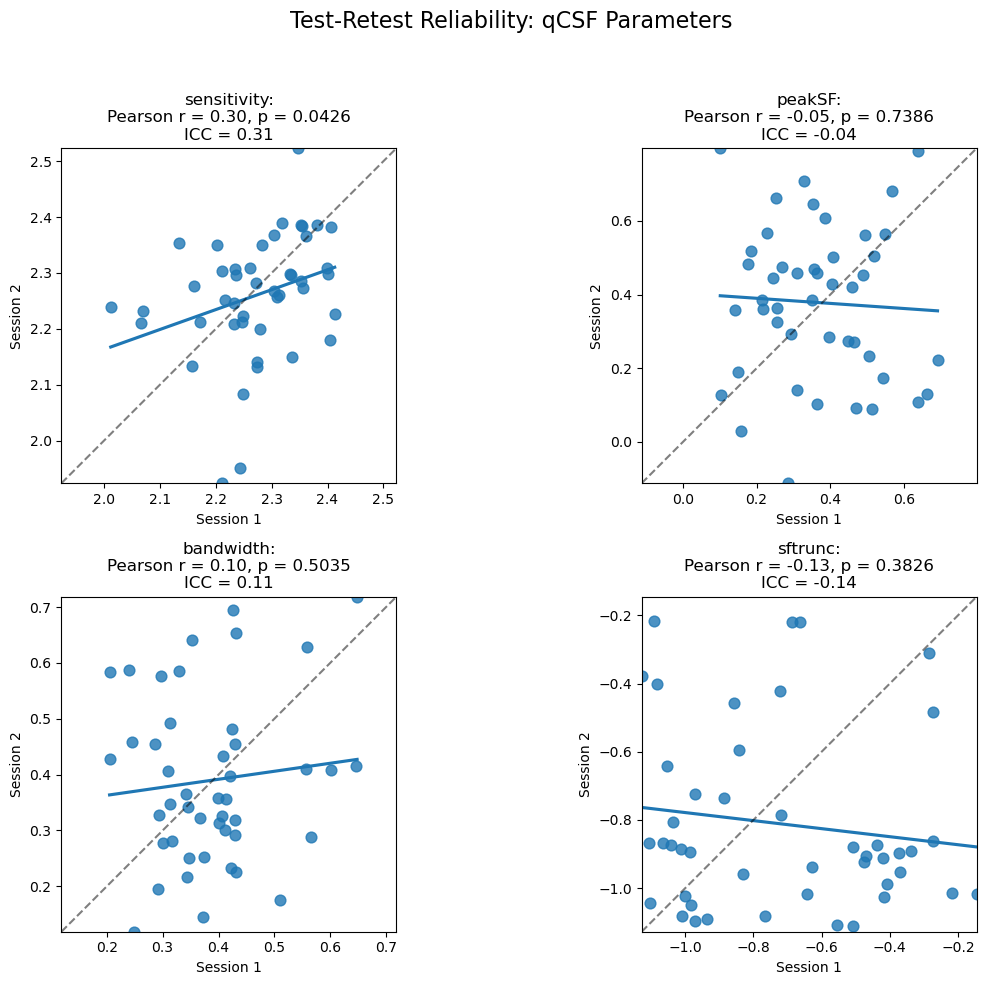

             pearson_r   p_value       icc
sensitivity   0.303562  0.042646  0.305231
peakSF       -0.051147  0.738630 -0.038563
bandwidth     0.102347  0.503492  0.107766
sftrunc      -0.133327  0.382596 -0.144981


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pingouin as pg  # for ICC

def analyze_and_plot(df, varname, ax):
    x = df[f'{varname}-1']
    y = df[f'{varname}-2']
    mask = ~x.isna() & ~y.isna()
    x_clean = x[mask]
    y_clean = y[mask]

    # Pearson correlation
    r, p = pearsonr(x_clean, y_clean)

    # ICC via pingouin
    icc_df = pd.DataFrame({
        'subject': df['subject'][mask].values.tolist() * 2,
        'session': [1]*len(x_clean) + [2]*len(y_clean),
        'score': pd.concat([x_clean, y_clean]).values
    })
    icc = pg.intraclass_corr(data=icc_df, targets='subject', raters='session',
                             ratings='score', nan_policy='omit')
    icc_val = icc.loc[icc['Type'] == 'ICC1', 'ICC'].values[0]

    # Plot
    sns.regplot(x=x_clean, y=y_clean, ax=ax, ci=None, scatter_kws={'s': 60})
    min_val = min(x_clean.min(), y_clean.min())
    max_val = max(x_clean.max(), y_clean.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax.set_title(f'{varname}:\nPearson r = {r:.2f}, p = {p:.4f}\nICC = {icc_val:.2f}')
    ax.set_xlabel('Session 1')
    ax.set_ylabel('Session 2')
    ax.set_aspect('equal', 'box')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])

    return r, p, icc_val

# ---------- Part 3: Run for all variables ---------- #

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
var_list = ['sensitivity', 'peakSF', 'bandwidth', 'sftrunc']
results = {}

for var, ax in zip(var_list, axs.flatten()):
    r, p, icc = analyze_and_plot(df, var, ax)
    results[var] = {'pearson_r': r, 'p_value': p, 'icc': icc}

plt.suptitle('Test-Retest Reliability: qCSF Parameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------- Optional: Save summary table ---------- #

results_df = pd.DataFrame(results).T
print(results_df)

In [5]:
##ttest for sftrunc

# Assign group
df['group'] = df['subject'].apply(lambda x: 'Patient' if str(x).startswith('1') else 'Control')

from scipy.stats import ttest_ind

# Drop NaNs for the column of interest
patients_data = df[df['group'] == 'Patient']['sftrunc-2'].dropna()
controls_data = df[df['group'] == 'Control']['sftrunc-2'].dropna()

# T-tests
t, p = ttest_ind(patients_data, controls_data, equal_var=False)

print(f"FIE_short t-test: t = {t:.3f}, p = {p:.3f}")


FIE_short t-test: t = 0.165, p = 0.870


Extracting sensitivity across 12 sf domains 

In [10]:
import os
import scipy.io
import numpy as np
import pandas as pd

def extract_estSens_row(mat_path):
    """Extract last row of estCSF array from a .mat file with nested structs."""
    mat_data = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    
    # Navigate the nested structs
    qcsf_struct = mat_data['qcsf']
    data_struct = qcsf_struct.data
    estSens = data_struct.estSensitivity  # estCSF should be 120x4
    return estSens[-1, :]  # last row

# Base directory (update this to your actual path)
base_dir = '/Volumes/Seagate Desktop Drive/AVP-BDD/behavior'
subject_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Store all data in a list of dicts
all_data = []

for subj in subject_dirs:
    subj_path = os.path.join(base_dir, subj, 'qCSF')
    if not os.path.exists(subj_path):
        continue

    # All .mat files for this subject
    mat_files = [f for f in os.listdir(subj_path) if f.endswith('.mat')]
    mat_files_dict = {  # key = session number
        '-1': None,
        '-2': None
    }

    for f in mat_files:
        if '-1_' in f:
            mat_files_dict['-1'] = f
        elif '-2_' in f:
            mat_files_dict['-2'] = f

    # Initialize row with subject ID and NaNs
    row = {
        'subject': subj,
        '0.25-1': np.nan, '0.3928-1': np.nan, '0.6171-1': np.nan, '0.9696-1': np.nan,'1.5233-1': np.nan, '2.3934-1': np.nan, '3.7604-1': np.nan, '5.9080-1': np.nan,'9.2824-1': np.nan, '14.5839-1': np.nan, '22.9133-1': np.nan, '36-1': np.nan,
        '0.25-2': np.nan, '0.3928-2': np.nan, '0.6171-2': np.nan, '0.9696-2': np.nan,'1.5233-2': np.nan, '2.3934-2': np.nan, '3.7604-2': np.nan, '5.9080-2': np.nan,'9.2824-2': np.nan, '14.5839-2': np.nan, '22.9133-2': np.nan, '36-2': np.nan
    }

    for session in ['-1', '-2']:
        mat_file = mat_files_dict[session]
        if mat_file is not None:
            mat_path = os.path.join(subj_path, mat_file)
            try:
                last_row = extract_estSens_row(mat_path)
                row[f'0.25{session}'] = last_row[0]
                row[f'0.3928{session}']      = last_row[1]
                row[f'0.6171{session}']   = last_row[2]
                row[f'0.9696{session}']     = last_row[3]
                row[f'1.5233{session}'] = last_row[4]
                row[f'2.3934{session}']      = last_row[5]
                row[f'3.7604{session}']   = last_row[6]
                row[f'5.9080{session}']     = last_row[7]
                row[f'9.2824{session}'] = last_row[8]
                row[f'14.5839{session}']      = last_row[9]
                row[f'22.9133{session}']   = last_row[10]
                row[f'36{session}']     = last_row[11]
            except Exception as e:
                print(f"Error loading {mat_file} for {subj}: {e}")

    all_data.append(row)

# Convert to DataFrame
df_sens = pd.DataFrame(all_data)



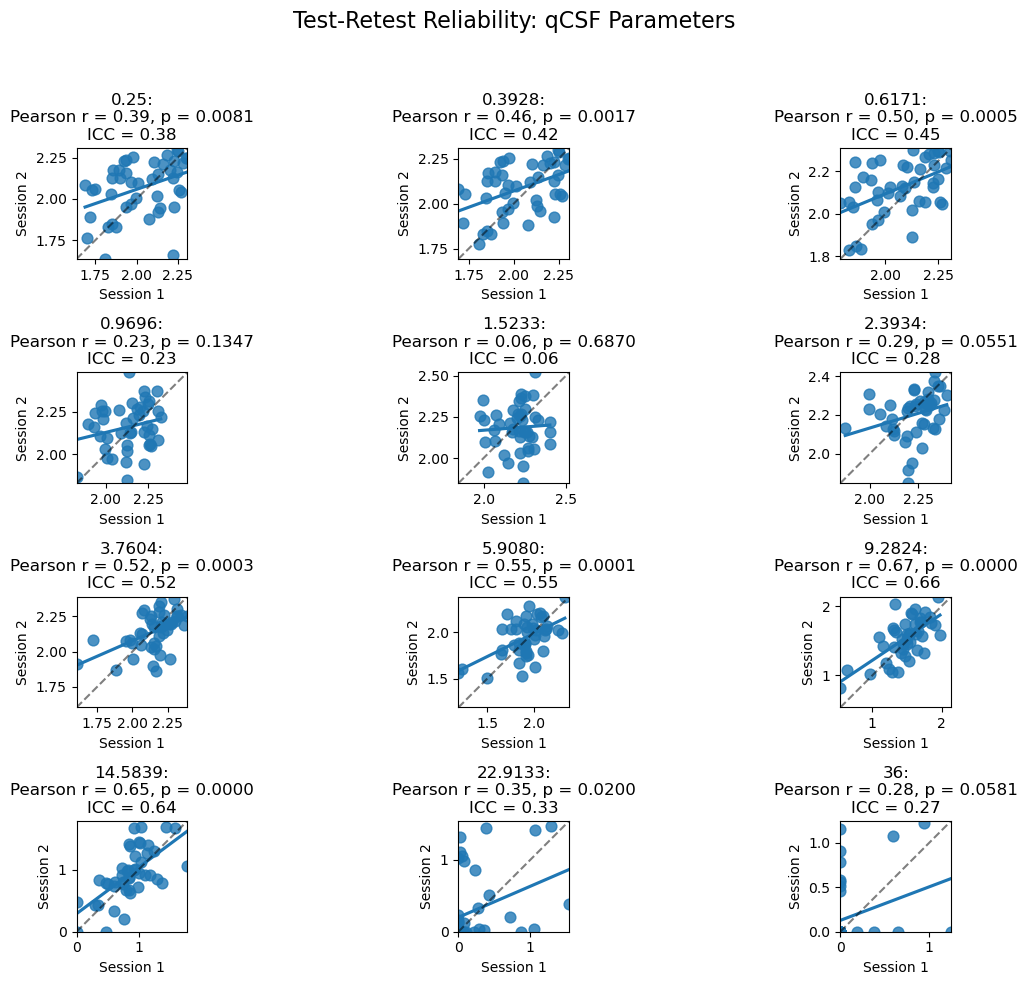

         pearson_r       p_value       icc
0.25      0.389822  8.119949e-03  0.380127
0.3928    0.455164  1.680541e-03  0.424247
0.6171    0.499179  4.819426e-04  0.450803
0.9696    0.226431  1.347301e-01  0.225449
1.5233    0.061739  6.870312e-01  0.062316
2.3934    0.287958  5.508891e-02  0.280067
3.7604    0.515667  2.886271e-04  0.515157
5.9080    0.551265  8.688464e-05  0.548835
9.2824    0.665963  5.959744e-07  0.655248
14.5839   0.652352  1.201414e-06  0.639449
22.9133   0.345769  1.999275e-02  0.334711
36        0.284658  5.806221e-02  0.266838


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pingouin as pg  # for ICC

def analyze_and_plot(df, varname, ax):
    x = df[f'{varname}-1']
    y = df[f'{varname}-2']
    mask = ~x.isna() & ~y.isna()
    x_clean = x[mask]
    y_clean = y[mask]

    # Pearson correlation
    r, p = pearsonr(x_clean, y_clean)

    # ICC via pingouin
    icc_df = pd.DataFrame({
        'subject': df['subject'][mask].values.tolist() * 2,
        'session': [1]*len(x_clean) + [2]*len(y_clean),
        'score': pd.concat([x_clean, y_clean]).values
    })
    icc = pg.intraclass_corr(data=icc_df, targets='subject', raters='session',
                             ratings='score', nan_policy='omit')
    icc_val = icc.loc[icc['Type'] == 'ICC1', 'ICC'].values[0]

    # Plot
    sns.regplot(x=x_clean, y=y_clean, ax=ax, ci=None, scatter_kws={'s': 60})
    min_val = min(x_clean.min(), y_clean.min())
    max_val = max(x_clean.max(), y_clean.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax.set_title(f'{varname}:\nPearson r = {r:.2f}, p = {p:.4f}\nICC = {icc_val:.2f}')
    ax.set_xlabel('Session 1')
    ax.set_ylabel('Session 2')
    ax.set_aspect('equal', 'box')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])

    return r, p, icc_val

# ---------- Part 3: Run for all variables ---------- #

fig, axs = plt.subplots(4, 3, figsize=(12, 10))
var_list = ['0.25','0.3928','0.6171', '0.9696','1.5233', '2.3934', '3.7604', '5.9080','9.2824', '14.5839', '22.9133', '36']
results = {}

for var, ax in zip(var_list, axs.flatten()):
    r, p, icc = analyze_and_plot(df_sens, var, ax)
    results[var] = {'pearson_r': r, 'p_value': p, 'icc': icc}

plt.suptitle('Test-Retest Reliability: qCSF Parameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------- Optional: Save summary table ---------- #

results_df = pd.DataFrame(results).T
print(results_df)

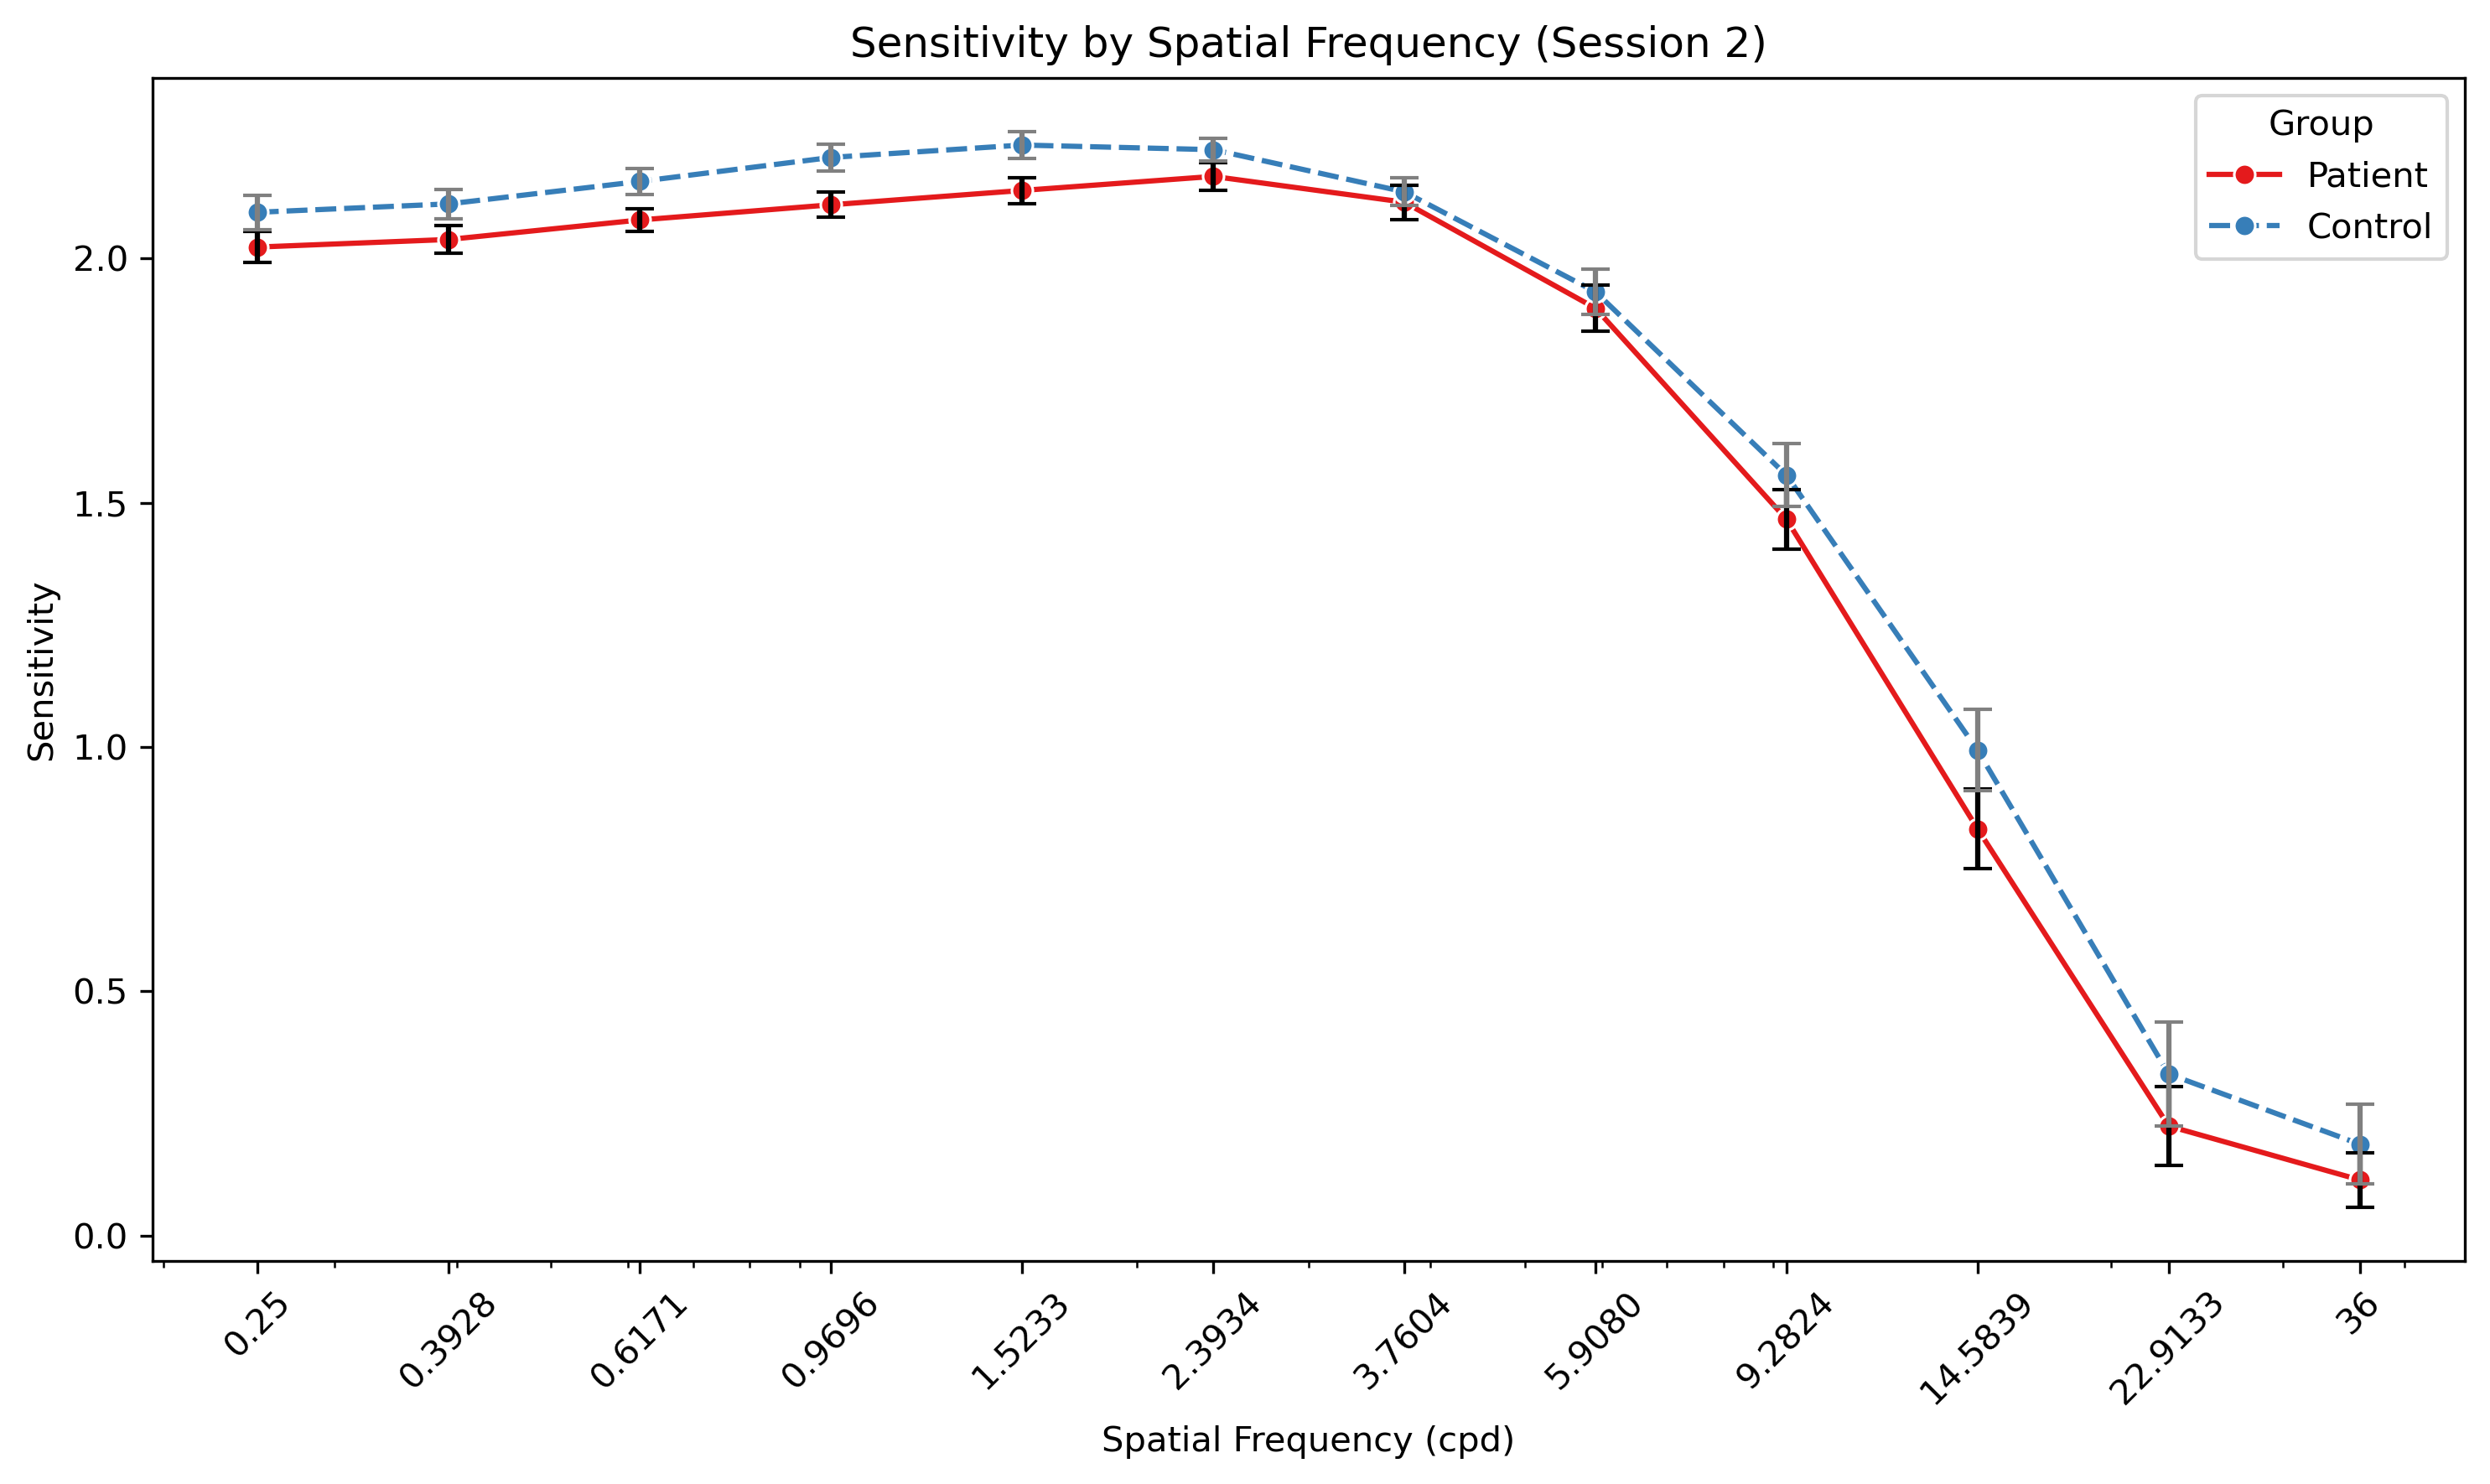

T-test Results (Patients vs Controls, Session 2):
 frequency         t      p
    0.2500 -1.498512 0.1409
    0.3928 -1.785777 0.0807
    0.6171 -2.230250 0.0308
    0.9696 -2.577729 0.0132
    1.5233 -2.438201 0.0186
    2.3934 -1.475292 0.1470
    3.7604 -0.469243 0.6411
    5.9080 -0.509792 0.6126
    9.2824 -1.019672 0.3132
   14.5839 -1.380166 0.1741
   22.9133 -0.795256 0.4309
   36.0000 -0.738957 0.4643


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

# Assign group
df_sens['group'] = df_sens['subject'].apply(lambda x: 'Patient' if str(x).startswith('1') else 'Control')

# Define spatial frequencies as strings (they match the keys in your dataframe)
freqs = ['0.25', '0.3928', '0.6171', '0.9696', '1.5233', '2.3934',
         '3.7604', '5.9080', '9.2824', '14.5839', '22.9133', '36']

# Store results
results = []
plot_data = []

for freq in freqs:
    colname = f'{freq}-2'
    patients = df_sens[df_sens['group'] == 'Patient'][colname].dropna()
    controls = df_sens[df_sens['group'] == 'Control'][colname].dropna()

    # T-test
    t, p = ttest_ind(patients, controls, equal_var=False)

    results.append({'frequency': float(freq), 't': t, 'p': p})

    # Store for plotting
    plot_data.append({
        'frequency': float(freq),
        'group': 'Patient',
        'mean': patients.mean(),
        'sem': patients.sem()
    })
    plot_data.append({
        'frequency': float(freq),
        'group': 'Control',
        'mean': controls.mean(),
        'sem': controls.sem()
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
plot_df = pd.DataFrame(plot_data)

# ---------- Plot ---------- #
plt.figure(figsize=(10, 6), dpi=300)
# sns.set(style='whitegrid')

# Line plot with error bars
sns.lineplot(data=plot_df, x='frequency', y='mean', hue='group', marker='o',
             err_style="bars", err_kws={'capsize': 4}, palette='Set1', style='group')

# Add error bars manually
for _, row in plot_df.iterrows():
    plt.errorbar(x=row['frequency'], y=row['mean'], yerr=row['sem'],
                 fmt='none', capsize=4, color='black' if row['group'] == 'Patient' else 'gray')

# Formatting
plt.xscale('log')
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Sensitivity')
plt.title('Sensitivity by Spatial Frequency (Session 2)')
plt.legend(title='Group')

# Set custom x-ticks and labels
freq_ticks = [float(f) for f in freqs]
plt.xticks(freq_ticks, labels=freqs, rotation=45)  # rotate if needed for readability

plt.tight_layout()
plt.show()

# ---------- Print Results ---------- #
print("T-test Results (Patients vs Controls, Session 2):")
print(results_df.to_string(index=False, formatters={'p': '{:.4f}'.format}))
